### PCA Feature Exploration

In [14]:
# imports
from transformers import ViTModel, ViTImageProcessor
import torch
from torch.utils.data import DataLoader
import gc
import pandas as pd
import numpy as np
import chromadb
import os
import pvlib
from pvlib import solarposition
from pvlib.solarposition import get_solarposition
import matplotlib.pyplot as plt
from astral.sun import sun
from astral import LocationInfo
import seaborn as sns


# import scripts
import dataloading
import model_functions
import data_vis

In [15]:
# load data
train = pd.read_csv('camera_data/dataframes/train', index_col=0)
val = pd.read_csv('camera_data/dataframes/val', index_col=0)
test = pd.read_csv('camera_data/dataframes/test', index_col=0)

In [16]:
# compute solar altitude for train, val, and test sets

lat, lon = 33.1, -117.146

# localize timestamps to pst
for df in [train, val, test]:
    df['datetime'] = (
        pd.to_datetime(df['timestamp'], unit='s')
        .dt.tz_localize('UTC')
        .dt.tz_convert('America/Los_Angeles')
    )

    solar_alt = pvlib.solarposition.get_solarposition(
        time=df['datetime'],
        latitude=lat,
        longitude=lon
    )['apparent_elevation']

    df['solar_alt'] = np.array(solar_alt)


# include sunrise and sunset times
loc = LocationInfo(latitude=lat, longitude=lon)
sunrise_times = []

for df in [train, val, test]:
    
    sunrise = []
    sunset = []
    for dt in df['datetime']:
        s = sun(loc.observer, date=dt.date(), tzinfo=dt.tz)
        sunrise.append(s['sunrise'])
        sunset.append(s['sunset'])
    df['sunrise'] = sunrise
    df['sunset'] = sunset


In [17]:
# load embedding data
persist_directory = "embedding_data/" 
client = chromadb.PersistentClient(path=persist_directory)
collection = client.get_or_create_collection(name="10-27-25_model_embeddings")

db_output = collection.get(ids = val['annotation_id'].astype(str).tolist(), include = ['embeddings'])
embeddings = db_output['embeddings']
labels = val['label']

db_df = pd.DataFrame(embeddings)
db_df['ids'] = db_output['ids']
db_df['ids'] = db_df['ids'].astype('int64')

db_df = db_df.merge(val, left_on = 'ids', right_on='annotation_id')

embeddings = db_df.filter(items = range(0, 768))
labels = db_df['label']

reduced_embeddings, labels = model_functions.reduce_pca(embeddings, labels, dimensions=4)

#### 1. feature 2 and solar altitude

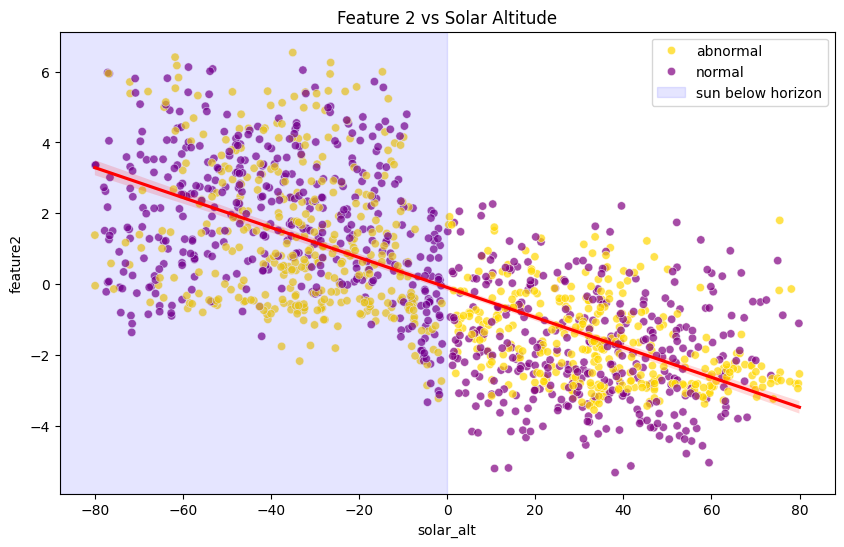

correlation between feature 2 and solar altitude: -0.7015


In [18]:
# extract feature 2 and solar altitude

feature2 = reduced_embeddings[:, 1]
solar_alt = np.array(db_df['solar_alt'])

# combine into df
df = pd.DataFrame({'feature2': feature2, 'solar_alt': solar_alt, 'label': labels})
df['label_name'] = df['label'].map({0: "normal", 1: "abnormal"})

# plot feature 2 vs solar altitude
plt.figure(figsize=(10, 6))
solar_plot = sns.scatterplot(data=df, x='solar_alt', y='feature2', hue='label_name', alpha=0.7,
                palette={'normal': 'purple', 'abnormal': 'gold'})



# plot horizon line
xmin, xmax = solar_plot.get_xlim()
solar_plot.set_xlim(xmin, xmax)
solar_plot.axvspan(xmin, 0, color='blue', alpha=0.1, label='sun below horizon')

# plot line of best fit
sns.regplot(data=df, x='solar_alt', y='feature2', scatter=False, 
            ax=solar_plot, color='red', line_kws={'label':"line of best fit"})

solar_plot.legend()
plt.title('Feature 2 vs Solar Altitude')
plt.show()

# correlation coefficient
correlation = df['feature2'].corr(df['solar_alt'])
print(f'correlation between feature 2 and solar altitude: {correlation:.4f}')

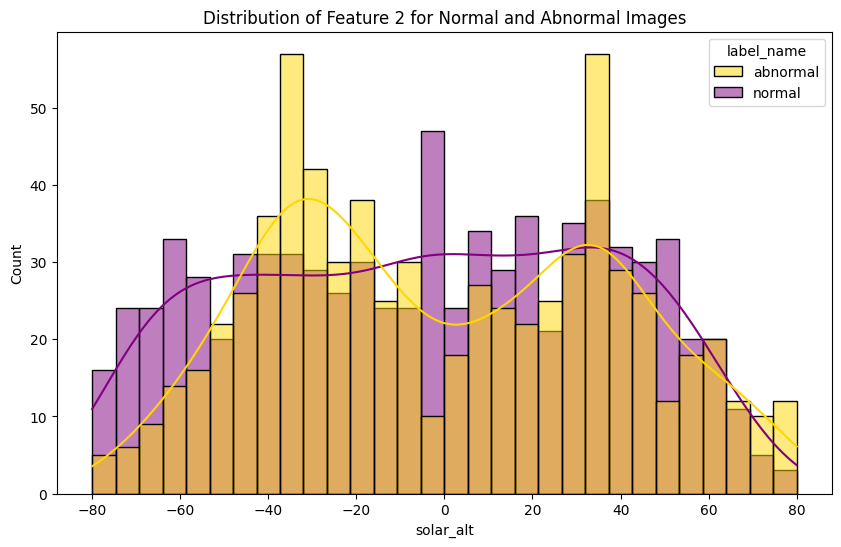

In [19]:
# distribution of solar altitude for normal and abnormal images
plt.figure(figsize=(10, 6))
dist_plot = sns.histplot(data=df, x='solar_alt', hue='label_name', kde=True,
                         palette={'normal': 'purple', 'abnormal': 'gold'}, alpha=0.5, bins=30)
plt.title('Distribution of Feature 2 for Normal and Abnormal Images')
plt.show()


There is a bimodal distribution of solar altitudes for abnormal images, suggesting that anomalies are more likely to be detected during certain times of the day. Specifically, abnormalities during the day occur most commonly when solar elevation is approximately 35-38, and abnormalities during the night occur most commonly when solar elecation is approximately -35 to -38. 

### time of day image distribution

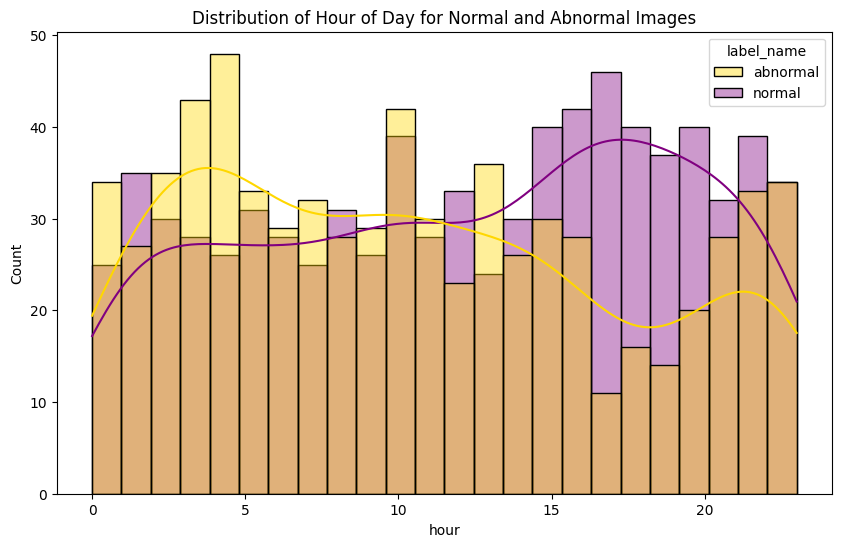

In [20]:
# add new column for hour of the day
df['hour'] = pd.to_datetime(db_df['datetime']).dt.hour

# distribution of hour of day for normal and abnormal images
plt.figure(figsize=(10, 6))
hour_plot = sns.histplot(data=df, x='hour', hue='label_name', kde=True,
                         palette={'normal': 'purple', 'abnormal': 'gold'}, alpha=0.4, bins=24)
plt.title('Distribution of Hour of Day for Normal and Abnormal Images')
plt.show()

Normal images are more common during daylight hours, while abnormal images are more evenly distributed throughout the day. However, abnormal images seem to peak from 3pm-8pm.

### feature 1 and solar altitude

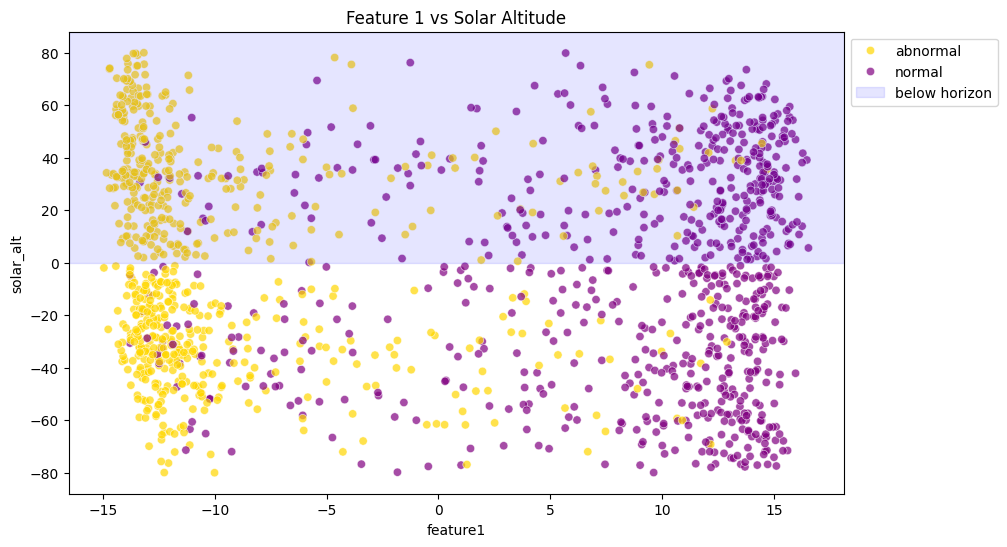

In [24]:
feature1 = reduced_embeddings[:, 0]
solar_alt = np.array(db_df['solar_alt'])

# combine into df
df = pd.DataFrame({'feature1': feature1, 'solar_alt': solar_alt, 'label': labels})
df['label_name'] = df['label'].map({0: "normal", 1: "abnormal"})

# plot feature 1 vs solar altitude
plt.figure(figsize=(10, 6))
solar_plot = sns.scatterplot(data=df, x='feature1', y='solar_alt', hue='label_name', alpha=0.7,
                palette={'normal': 'purple', 'abnormal': 'gold'})


ymin, ymax = solar_plot.get_ylim()
solar_plot.set_ylim(ymin, ymax)
solar_plot.axhspan(0, ymax, color='blue', alpha=0.1, label='below horizon')
solar_plot.legend()
sns.move_legend(solar_plot, "upper left", bbox_to_anchor=(1, 1))
plt.title('Feature 1 vs Solar Altitude')
plt.show()

In [22]:
# combine features into numpy array
feature_df = np.vstack((feature2, solar_alt)).T

# plot feature 2 vs solar altitude
# data_vis.plot_data(feature_df, labels)